In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import yaml
import sys
sys.path.append('./../..')

import os
BASE_PATH = './../dynaphos-core/'
sys.path.append(BASE_PATH)

from dynaphos import utils

import pandas as pd
import seaborn as sns

from scipy.optimize import curve_fit
from scipy.stats import linregress, norm

import matplotlib.pyplot as plt

# import tqdm
# from tqdm.notebook import trange, tqdm
from tqdm import tqdm as notebook_tqdm

COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')
plt.style.use('../_figurestyle/small.mplstyle')
# %matplotlib qt
params = utils.load_params('../dynaphos-core/config/params_surface.yaml')


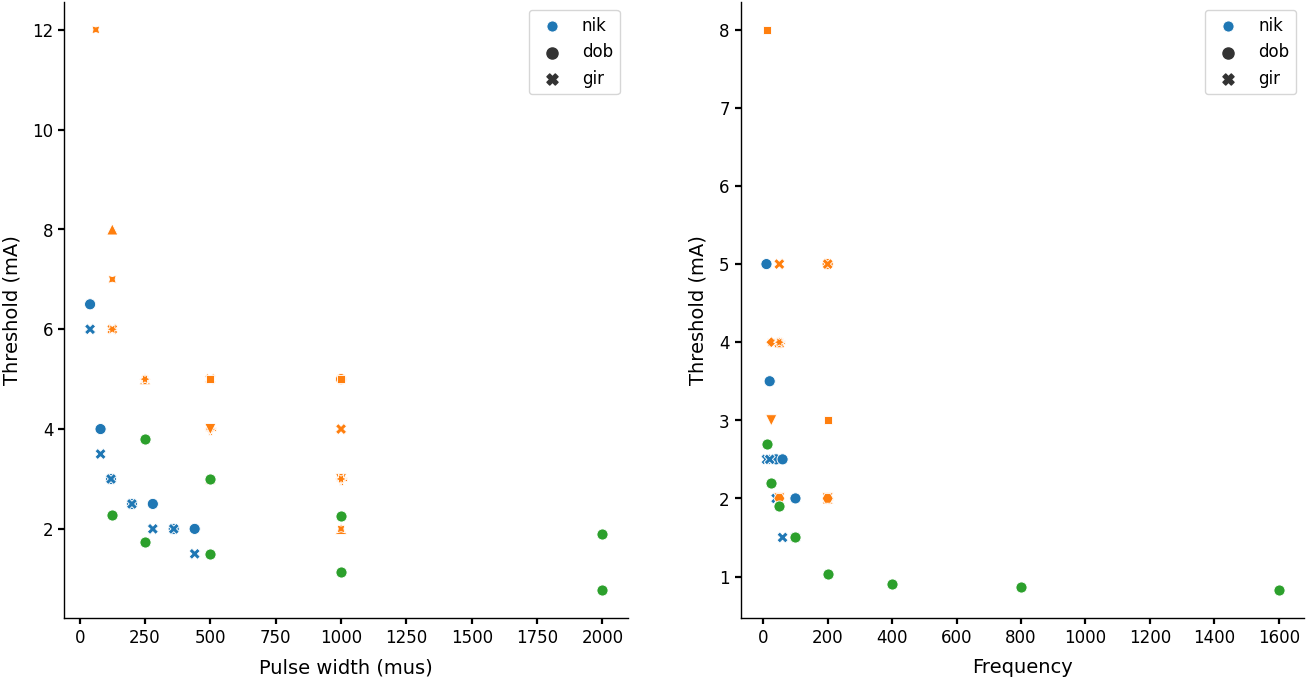

In [4]:
# Default stimulation parameters in Fernandez et al 2021
DEFAULT = pd.Series({'pulse_width'    : 170e-6,
                     'frequency'      : 300,
                     'train_duration' : 166e-3})

# Proportion of phosphene perception in figure 2 Fernandez et al 2021
PROPORTIONS = pd.read_csv('data/Fernandez_et_al_2021_fig2.csv',float_precision='high')

# 50 percent detection thresholds (based on the fit by Fernandez et al fig 2)
THRESHOLDS_nik  = pd.read_csv('data/Niketeghad_2020_thresholds.csv',float_precision='high', delimiter=';')
THRESHOLDS_dob  = pd.read_csv('data/Dobelle_1974_thresholds.csv',float_precision='high', delimiter=';')
THRESHOLDS_gir  = pd.read_csv('data/Girvin_1979_thresholds.csv',float_precision='high', delimiter=';')

## VISUALIZE
fig, axs = plt.subplots(1,2,figsize=(8,4),dpi=200)
sns.scatterplot(data=THRESHOLDS_nik[(THRESHOLDS_nik['Subfigure'].isin(['A','B'])) & (THRESHOLDS_nik['Figure'] == 3) ], x='Pulse width (mus)', y = 'Threshold (mA)', style='Contact', ax=axs[0])
sns.scatterplot(data=THRESHOLDS_nik[(THRESHOLDS_nik['Subfigure'].isin(['A','B'])) & (THRESHOLDS_nik['Figure'] == 4) ], x='Frequency', y = 'Threshold (mA)', style='Contact', ax=axs[1])

sns.scatterplot(data=THRESHOLDS_dob[THRESHOLDS_dob['table'] == 3], x='pulse_width', y = 'amplitude (mA)', style='contact', ax=axs[0])
sns.scatterplot(data=THRESHOLDS_dob[THRESHOLDS_dob['table'] == 4], x='frequency', y = 'amplitude (mA)', style='contact', ax=axs[1])

sns.scatterplot(data=THRESHOLDS_gir[THRESHOLDS_gir['figure'] == 4], x='pulse_width', y = 'amplitude (mA)', ax=axs[0])
sns.scatterplot(data=THRESHOLDS_gir[THRESHOLDS_gir['figure'] == 5], x='frequency', y = 'amplitude (mA)', ax=axs[1])

axs[0].legend(['nik', 'dob', 'gir'])
axs[1].legend(['nik', 'dob', 'gir'])

plt.show()
# fig, axs = plt.subplots(2,2,figsize=(7,7),dpi=200)
# axs = axs.ravel()

# for i, ax,  in enumerate(axs):
    
# fig, axs = plt.subplots(1,3,figsize=(15,5),dpi=200)
# for i, (label, param) in enumerate([ ('fig2A','pulse_width'),
#                                     ('fig2B','frequency'),
#                                     ('fig2C','train_duration')]):
#     sns.lineplot(data=PROPORTIONS.loc[PROPORTIONS.label==label],
#                  x='charge_per_phase',
#                  y='proportion_phosphene_perception',
#                  hue=param,
#                  ax = axs[i])
#     axs[i].set(title=f'{label} (reproduced)')
#     axs[i].axhline(0.5, color='k', linestyle=':')

# plt.tight_layout()

## Uncomment to look at the detection thresholds
# THRESHOLDS

In [5]:
THRESHOLDS_nik.rename(columns = {'Pulse width (mus)': 'pulse_width',
                              'Frequency': 'frequency',
                              'Train duration (ms)': 'train_duration',
                              'Charge per trial (muC)': 'charge_per_trial', 
                              'Threshold (mA)': 'amplitude',
                              'Number of pulses': 'number_of_pulses',
                              'Figure': 'figure',
                              'Subfigure': 'subfigure',
                              'Contact' : 'contact'
                             }, inplace = True)

THRESHOLDS_dob.rename(columns = {'amplitude (mA)': 'amplitude'}, inplace = True)
THRESHOLDS_gir.rename(columns = {'amplitude (mA)': 'amplitude'}, inplace = True)

def to_right_oom(data):
    data['pulse_width'] = data['pulse_width']*1e-6 
    data['train_duration'] = data['train_duration']*1e-3
    if 'charge_per_trial' in data.columns:
        data['charge_per_trial'] = data['charge_per_trial']*1e-6
    data['amplitude'] = data['amplitude']*1e-3
    return data

def add_complementary_parameters(data):
    data['duty_cycle'] = data.pulse_width*data.frequency
    data['charge_per_phase'] = data.pulse_width*data.amplitude#data.charge_per_trial/data.duty_cycle
    if 'charge_per_trial' not in data.columns:
        data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration
    data['corrected_duration'] = data.duty_cycle * data.train_duration
    return data

to_right_oom(THRESHOLDS_nik)
add_complementary_parameters(THRESHOLDS_nik)

to_right_oom(THRESHOLDS_dob)
add_complementary_parameters(THRESHOLDS_dob)

to_right_oom(THRESHOLDS_gir)
add_complementary_parameters(THRESHOLDS_gir)
print(THRESHOLDS_nik.head())
print(THRESHOLDS_dob.head())
print(THRESHOLDS_gir.head())

   figure subfigure contact  pulse_width  frequency  train_duration   
0       3         A      A1      0.00004         20            0.25  \
1       3         A      A1      0.00008         20            0.25   
2       3         A      A1      0.00012         20            0.25   
3       3         A      A1      0.00020         20            0.25   
4       3         A      A1      0.00028         20            0.25   

   amplitude  number_of_pulses  charge_per_trial  duty_cycle   
0     0.0065               5.0          0.000001      0.0008  \
1     0.0040               5.0          0.000002      0.0016   
2     0.0030               5.0          0.000002      0.0024   
3     0.0025               5.0          0.000002      0.0040   
4     0.0025               5.0          0.000003      0.0056   

   charge_per_phase  corrected_duration  
0      2.600000e-07              0.0002  
1      3.200000e-07              0.0004  
2      3.600000e-07              0.0006  
3      5.000000e-07 

In [4]:
# def add_complementary_parameters(data):
#     data['amplitude']  = data.charge_per_phase/data.pulse_width
#     data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration
#     data['duty_cycle'] = data.pulse_width*data.frequency
#     data['corrected_duration'] = data.duty_cycle * data.train_duration
#     return data

# # Calculate other descriptive parameters and add to the dataframe
# add_complementary_parameters(PROPORTIONS)
# add_complementary_parameters(THRESHOLDS)

In [18]:
len(THRESHOLDS_dob)

72

In [4]:
# limit = 1e-2
# THRESHOLDS_nik = THRESHOLDS_nik[THRESHOLDS_nik['corrected_duration']<limit]
# THRESHOLDS_dob = THRESHOLDS_dob[THRESHOLDS_dob['corrected_duration']<limit]
# THRESHOLDS_gir = THRESHOLDS_gir[THRESHOLDS_gir['corrected_duration']<limit]


In [11]:
limit = 1e-4
THRESHOLDS_nik = THRESHOLDS_nik[THRESHOLDS_nik['corrected_duration']>limit]
THRESHOLDS_dob = THRESHOLDS_dob[THRESHOLDS_dob['corrected_duration']>limit]
THRESHOLDS_gir = THRESHOLDS_gir[THRESHOLDS_gir['corrected_duration']>limit]

In [16]:
def r_squared(xdata,ydata,ypred):
    residuals = ydata - ypred
    # print(residuals)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

chronaxie_all = []
rheobase_all = []
r_values_all = []
n_splits = 3

for dataset, data_name in zip([THRESHOLDS_nik, THRESHOLDS_dob, THRESHOLDS_gir],['Niketeghad', 'Dobelle', 'Girvin']):
    print(f'working on {data_name}')
    rheobase_list = []
    chronaxie_list = []
    r_values_cpt = []
    
    rng = np.random.default_rng()
    idxs = np.arange(len(dataset))
    rng.shuffle(idxs)
    test_splits = np.split(idxs,np.linspace(len(idxs)/(n_splits-1),len(idxs),n_splits-1,dtype=int, endpoint=False))

    for split in test_splits:
        test_idxs = np.zeros(len(dataset),dtype=bool)
        test_idxs[split] = True
        print(split)#, ~test_idxs)
        thresholds_data = dataset.copy()
        train_data = thresholds_data[~test_idxs]
        test_data = thresholds_data[test_idxs]

        # charge-duration curve
        CD_fit = lambda duration,rheobase,chronaxie: rheobase*duration + chronaxie*rheobase
        x, y = train_data.corrected_duration, train_data.charge_per_trial
        fitParam, fitCov = curve_fit(CD_fit,x,y)
        rheobase, chronaxie = fitParam
        rheobase_list.append(rheobase)
        chronaxie_list.append(chronaxie)

        # strength-duration curve
        SD_fit = lambda duration,rheobase,chronaxie: rheobase*(1+chronaxie/duration)

        ### UNCOMMENT TO FIT ON AMPLITUDES INSTEAD OF CHARGE PER TRIAL
        # x, y = data.corrected_duration, data.amplitude
        # fitParam, fitCov = curve_fit(SD_fit,x,y)
        # rheobase, chronaxie = fitParam

        # CALCULATE R-squared
        r2_cpt = r_squared( xdata = test_data['corrected_duration'],
                            ydata = test_data['charge_per_trial'],
                            ypred = test_data['corrected_duration']*rheobase + chronaxie*rheobase)
        print(f'R^2 : {r2_cpt}')


        r_values_cpt.append(r2_cpt)
        
    chronaxie_all.append(chronaxie_list)
    rheobase_all.append(rheobase_list)
    r_values_all.append(r_values_cpt)


working on Niketeghad
[23 34 35 59  1 43 58 10 60  4 30  6 11 19 45 14  7  5 32 28 48 26 15 20
 46 29 18 13 44 36 16]
R^2 : 0.8449562874034617
[47 61  9 41 12 31 33 54  2 37 51 38 42 49 56]
R^2 : 0.9071494770921033
[39  0 40 55 57 52 22  3 53 21 50 25 24  8 17 27]
R^2 : 0.8664812204325231
working on Dobelle
[53 37 68 24 50 30 66 29 46 14 32 17 60 49 40  6 61 13 54 28  2 27 25 18
 20 42 45 58 63 57  8 52  3 34  1 16]
R^2 : 0.6342291259115223
[21 12  9 51 23 59 67 36 35 43 11 44  4 55 15 41 31 22]
R^2 : 0.4924557891005693
[ 0 26  7 39 56 70 64 10 62 69 48 47 19 38  5 33 65 71]
R^2 : 0.7198859545070089
working on Girvin
[11 20 18  7 24 12  5  2  1  3  0  4]
R^2 : 0.9348321937611774
[14 16 23  8 15 10]
R^2 : 0.8280324960613612
[ 9 22  6 21 17 13 19]
R^2 : 0.9951629636881868


In [17]:
for r in r_values_all:
    print(np.mean(r))

0.8728623283093627
0.6155236231730334
0.9193425511702418


In [33]:
np.mean(rheobase_all)

0.0016588825348767525

start for


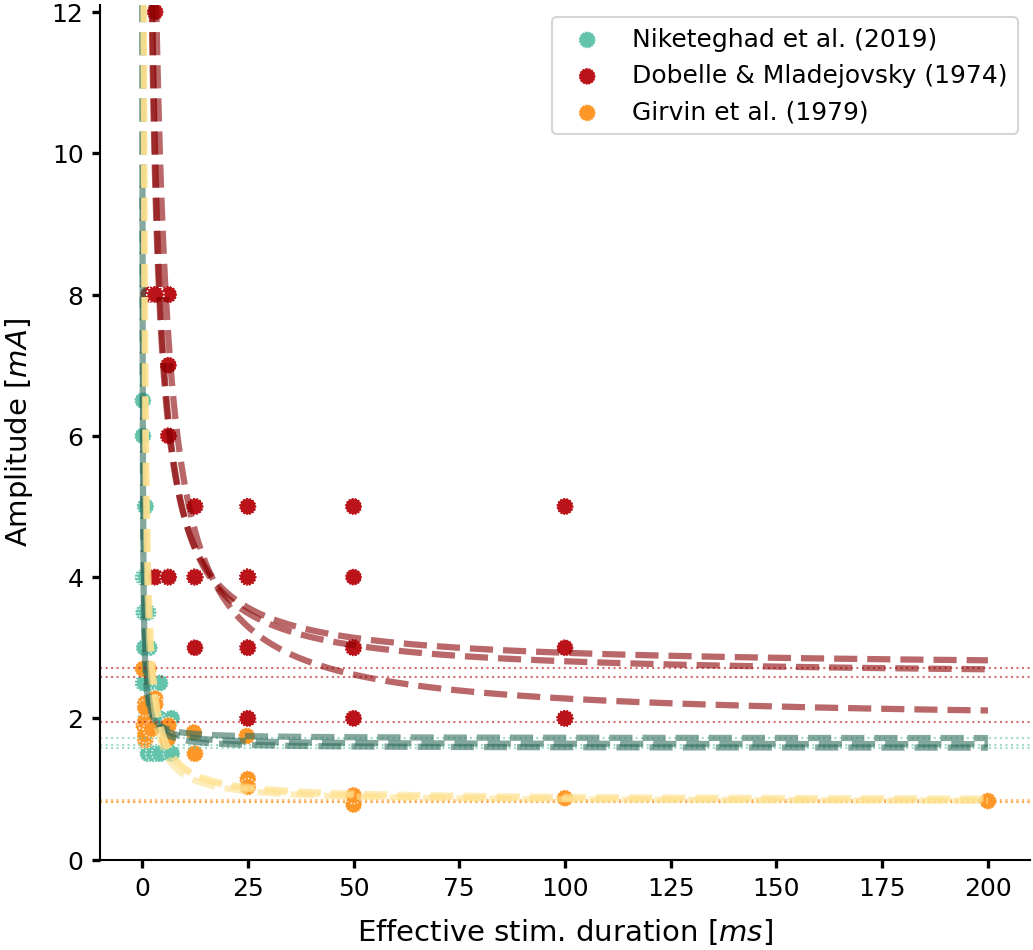

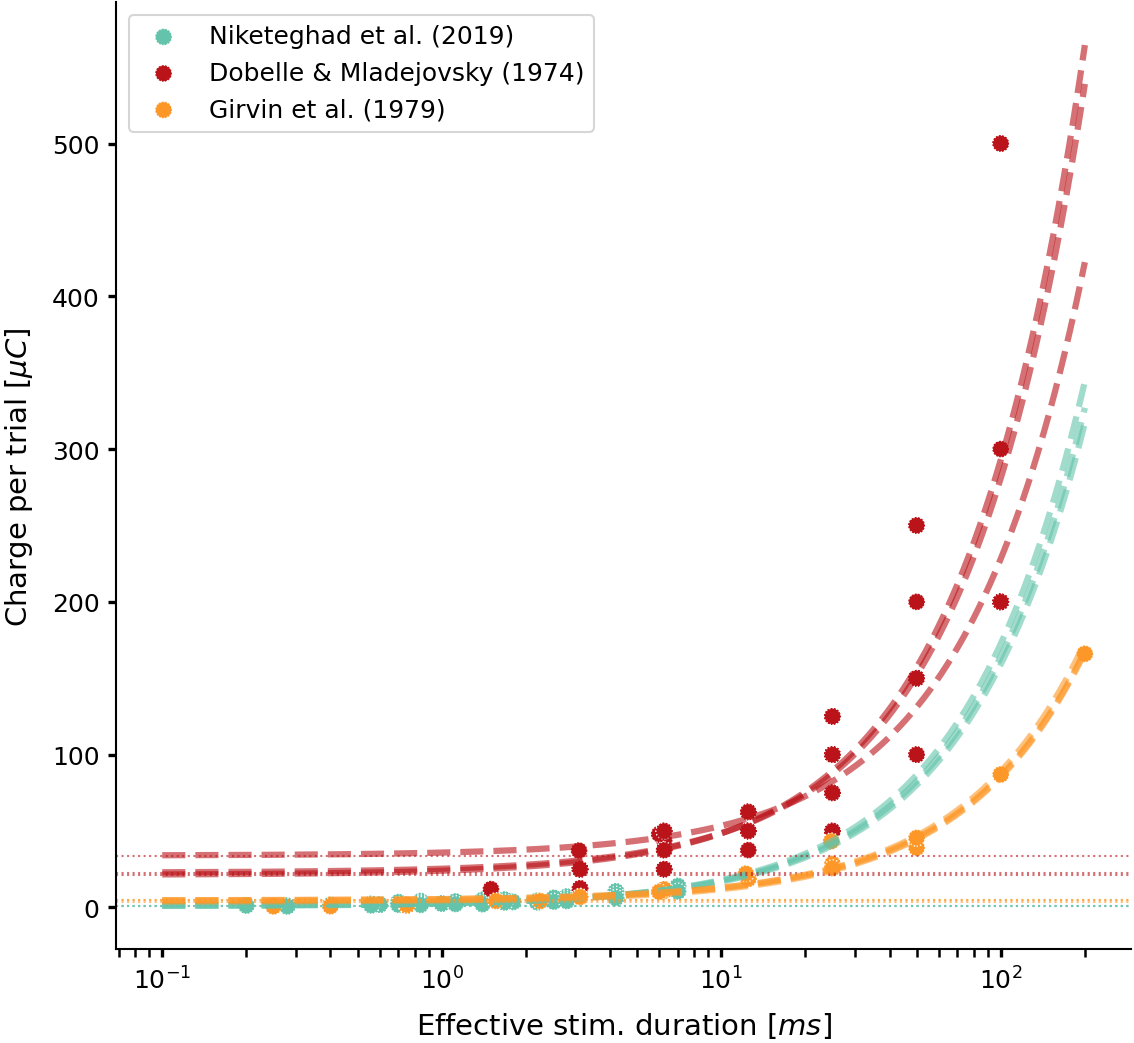

In [25]:
plt.style.use('../_figurestyle/small.mplstyle')
def plot_sd_curves(data_names, datasets, rheobases, chronaxies):
    ### 1.  Amplitude curve
    fig1, ax1 = plt.subplots(1,1,figsize=(4,3.7), dpi=300,)#fig, axs = plt.subplots(2,2, figsize=(4,3.7), dpi=300)
    fig2, ax2 = plt.subplots(1,1,figsize=(4,3.7), dpi=300,)
    t = np.linspace(1e-4,0.2,3000)
    print('start for')
    for data_name, data, color, rheobase, chronaxie in zip(data_names, datasets, [COLORSTYLE['turquoise'], COLORSTYLE['red'], COLORSTYLE['orange']], rheobases, chronaxies):
    # color=COLORSTYLE['red'][0]
    # print(color)
        # rheobase=np.mean(rheobase)
        # chronaxie=np.mean(chronaxie)
    # print(rheobase, chronaxie)
    # for data in datasets:
        # print(data.head())
        sns.scatterplot(x=data.corrected_duration*1e3,
                        y=data.amplitude *1e3,
                        linestyle = ':',
                        hue=None,
                        ax=ax1,
                        c=color[1],
                        label=data_name)
        # ax1.set_xscale('log')
        ax1.set(xlabel='Effective stim. duration [$ms$]',
                   ylabel='Amplitude [$m A$]',
                   # xlim = [1e-1,10],
                   ylim = [0,12.1])


        # # line for the rheobase (I_0)
        for r in rheobase:
            handle = ax1.axhline(r*1e3, color=color[1], alpha = 0.6, linestyle=':', linewidth=0.5,)
            
        # handle.set_label(data_name)
        # ax.text(10,rheobase*1e3, '$I_0$',  bbox={'color':'white','fill':True})

        # line and text for the amplitude curve fit
        for r,c in zip(rheobase,chronaxie):
            ax1.plot(t*1e3, SD_fit(t,r,c)*1e3, '--', c=color[0], alpha = 0.6)
        # ax.text(7, rheobase *1.4e3, 
        #             '$I_{thr}(t) = I_0 (1 + c / t)$',
        #             rotation = -2,)

        ### 2. Charge plot

        sns.scatterplot(x=data.corrected_duration*1e3,
                        y=data.charge_per_trial *1e6,
                        linestyle = ':',
                        hue=None,
                        ax=ax2,
                        c=color[1],
                        label=data_name)
        ax2.set_xscale('log')
        
        ax2.set(xlabel='Effective stim. duration [$ms$]',
                   ylabel='Charge per trial [$\mu C$]')
                   # ylim = [0,15],
                   # xlim = [0,10] )

        # Line for the intercept (rheobase x chronachie <==> I_0 x c)
        for r,c in zip(rheobase,chronaxie):
            handle = ax2.axhline(r*c*1e6, color=color[1], alpha = 0.6, linestyle=':', linewidth=0.5,)
        # ax.text(2,rheobase*chronaxie*0.9e6, '$I_0 \cdot c$',  bbox={'color':'white','fill':True})
        # handle.set_label(data_name)
        
        ## Line and text for the curve fit
        for r,c in zip(rheobase,chronaxie):
            ax2.plot(t*1e3, (t*r + c*r)*1e6, '--', color=color[1], alpha = 0.6)
        # ax.text(3, (15e-3 * rheobase + chronaxie*rheobase-1e-7)*1e3, 
        #             '$Q_0(t) = I_0 \cdot t + I_0 \cdot c$',
        #             fontsize=20,
        #             rotation = 32,)

        # # Text with R^2 value
        # ax.text(2.5,1.12,f'$R^2 = {r2_cpt:0.3f}$',
        #             bbox={'color':'white','fill':True},
        #             fontsize = 20, horizontalalignment = 'right')
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
        
plot_sd_curves(['Niketeghad et al. (2019)', 'Dobelle & Mladejovsky (1974)', 'Girvin et al. (1979)'],[THRESHOLDS_nik, THRESHOLDS_dob, THRESHOLDS_gir], rheobase_all, chronaxie_all)

In [6]:
def get_additional_stim_data(n_datapoints=150, I_max=120e-6, ):
    """Produce some new stimulation datapoints, for evaluating the (simulated) effects.
    Using more datapoints can be helpful for a smooth visualization of the modelled responses."""
    i = np.linspace(0.,I_max, n_datapoints)
    pws = np.array([100e-6, 170e-6, 400e-6,800e-6,])
    fs = np.array([100.,200.,300.])
    dur = np.array([50.*1e-3, 83.*1e-3, 166.*1e-3])

    PW, F, TD, I = np.meshgrid(pws,fs,dur,i) ### all permutations of I, pw fs and duration
    data = pd.DataFrame({'pulse_width': PW.flatten(),
                         'frequency': F.flatten(),
                         'train_duration': TD.flatten(),
                         'amplitude': I.flatten(),
                         'mask_pulse_width': False,
                         'mask_frequency': False,
                         'mask_train_duration': False})
    data['charge_per_phase']  = data.amplitude*data.pulse_width
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration

    #
    data.loc[(data.frequency == DEFAULT.frequency) & (data.train_duration == DEFAULT.train_duration), 'mask_pulse_width'] = True
    data.loc[(data.pulse_width == DEFAULT.pulse_width) & (data.train_duration == DEFAULT.train_duration), 'mask_frequency'] = True
    data.loc[(data.frequency == DEFAULT.frequency) & (data.pulse_width == DEFAULT.pulse_width), 'mask_train_duration'] = True
    return data

def get_additional_stim_data2(thresholds, n_datapoints=150, I_max=120e-6):
    data = []
    for index, row in thresholds.iterrows():
        for i in np.linspace(0., I_max, n_datapoints):
            pw, f, td = row[['pulse_width', 'frequency', 'train_duration']]
            entry = [pw, f, td, i, False, False, False]
            data.append(entry)
    data = pd.DataFrame(data, columns=['pulse_width',
                                       'frequency',
                                       'train_duration',
                                       'amplitude',
                                       'mask_pulse_width',
                                       'mask_frequency',
                                       'mask_train_duration'])

    data['charge_per_phase']  = data.amplitude*data.pulse_width
    data['charge_per_trial'] = data.charge_per_phase * data.frequency * data.train_duration

    #
    data.loc[(data.frequency == DEFAULT.frequency) & (data.train_duration == DEFAULT.train_duration), 'mask_pulse_width'] = True
    data.loc[(data.pulse_width == DEFAULT.pulse_width) & (data.train_duration == DEFAULT.train_duration), 'mask_frequency'] = True
    data.loc[(data.frequency == DEFAULT.frequency) & (data.pulse_width == DEFAULT.pulse_width), 'mask_train_duration'] = True
    return data



In [7]:
test_virt = get_additional_stim_data2(THRESHOLDS, 100, 7e-3)
test_virt.shape

(6200, 9)

In [8]:
FPS = 1000

def run_experiment(X_IN,
                   trace_decay_constant = -np.log( 0.99949191),
                   trace_increase_rate = 13.95528162,
                   act_decay_constant = 9.,
                   rheobase = 23.9e-6,
                   pulse_width = 100e-6,
                   frequency = 200,
                   dt = 1/32,):

    # Stimulation sequence
    stim = X_IN.copy()
    n_steps = len(stim)
    T = n_steps*dt

    # Initialize output arrays
    stim_input = np.zeros(n_steps) # JR: effective stimulation
    trace = np.zeros(n_steps) #long-term memory trace
    activation = np.zeros(n_steps) #output
    leak = np.zeros(n_steps)


    #run experiment
    for t in range(n_steps):

        ## TODO: REMOVE!!!
#         trace = np.zeros(n_steps)

        if t>0:

            # remainder after decay from previous time step
            activation[t] = activation[t-1]
            activation[t] -= act_decay_constant * activation[t-1] * dt

            # new input
            leak_current  = trace[t-1] + rheobase

#             # TODO: REMOVE!!!
#             leak_current  = 0


            stim_input[t] = (stim[t] - leak_current) * pulse_width * frequency
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t] * dt

            # trace update
            trace[t] = trace[t-1]
            trace[t] -= trace_decay_constant * trace[t-1] * dt
            trace[t] += trace_increase_rate * stim_input[t] * dt



            leak[t]  = leak_current

        else:
            # In the first frame, ignore the previous time step (there is none)
            stim_input[t] = (stim[t] - rheobase) * pulse_width * frequency * dt
            stim_input[t] = max(0,stim_input[t])
            activation[t] += stim_input[t]

            leak[t]  = rheobase

    return activation, trace, stim


## The simulator model
def get_max_activation(amplitude=90e-6,
                       pulse_width=170e-6,
                       frequency=300,
                       stim_duration=166e-3,
                       rheobase=23.9e-6,
                       act_decay_constant = 9,
                       fps=1000):

    sequence = get_stim_sequence(stim_duration, amplitude, fps)

    activation, trace, stim = run_experiment(sequence,
                                             pulse_width = pulse_width,
                                             frequency = frequency,
                                             rheobase = rheobase,
                                             act_decay_constant = act_decay_constant,
                                             dt = 1/fps)


    return activation.max()

def get_stim_sequence(stim_duration=166e-3, amplitude=90e-6, fps=1000,):
    stim_frames = int(stim_duration*fps)
    sequence = np.concatenate([np.ones(stim_frames), np.zeros(fps-stim_frames)])
    return amplitude * sequence




In [9]:
def calc_modeled_activation(data, fps=1000, rheobase=23.9e-6,act_decay_constant = 9.,trace_decay_constant = -np.log( 0.99949191),trace_increase_rate = 13.95528162,):
    # Simplified model output
    data['total_charge_loss_'] = rheobase * data.pulse_width * data.frequency * data.train_duration
    data['total_effective_charge_'] = data.charge_per_trial - data.total_charge_loss_

    activations = []
    traces = []
    stimulations = []

    # Model output after providing stimulation sequence
    for i,specs in notebook_tqdm(data.iterrows(), total=len(data)):

        sequence = get_stim_sequence(stim_duration=specs.train_duration,
                                     amplitude=specs.amplitude,
                                     fps=fps)

        activation, trace, stim = run_experiment(sequence,
                                                 pulse_width = specs.pulse_width,
                                                 frequency = specs.frequency,
                                                 rheobase=rheobase,
                                                 act_decay_constant = act_decay_constant,
                                                 trace_decay_constant = trace_decay_constant,
                                                 trace_increase_rate = trace_increase_rate,
                                                 dt = 1/fps)



        data.loc[i,'max_activation_'] = activation.max()

        activations.append(activation)
        traces.append(trace)
        stimulations.append(stim)

    return activations, traces, stimulations



In [10]:
ACTIVATION_DECAY = -np.log(params['temporal_dynamics']['activation_decay_per_second'])
TRACE_DECAY = -np.log(params['temporal_dynamics']['trace_decay_per_second'])
TRACE_INCREASE = params['temporal_dynamics']['trace_increase_rate']


# Copy the datapoints from Fernandéz et al
data = PROPORTIONS.copy()

# Get some additional stimulation data (virtual datapoints, for simulation)
n_datapoints = 30
virtual_data = get_additional_stim_data2(THRESHOLDS, n_datapoints=n_datapoints, I_max=6.5e-3) # to create a smooth curve of the predicted response
#virtual_data = virtual_data.merge(THRESHOLDS[['pulse_width','frequency','train_duration']]).drop_duplicates()

In [11]:
virtual_data.shape

(1860, 9)

In [12]:
# Calculate the modelled activation (run experiments for each of the datapoints)
calc_modeled_activation(data,
                        act_decay_constant= ACTIVATION_DECAY,
                        trace_decay_constant = TRACE_DECAY,
                        trace_increase_rate = TRACE_INCREASE,
                   )
activations, traces, stimulations = calc_modeled_activation(virtual_data,
                                                            act_decay_constant= ACTIVATION_DECAY,
                                                            trace_decay_constant = TRACE_DECAY,
                                                            trace_increase_rate = TRACE_INCREASE) #, act_decay_constant = 1.)

AttributeError: 'DataFrame' object has no attribute 'charge_per_trial'

In [12]:
#remove when everything works
proportions = data.copy()
v_copy = virtual_data.copy()

In [38]:
def r_squared(xdata,ydata,ypred):
    residuals = ydata - ypred
    print(residuals)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((ydata-np.mean(ydata))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

y_true_list = [None] * len(THRESHOLDS)
y_pred_list = [None] * len(THRESHOLDS)
y_pred_interp_list = [None] * len(THRESHOLDS)
r_values_thresholds = []
r_values_cpt = []
for split in test_splits:
    test_idxs = np.zeros(len(THRESHOLDS),dtype=bool)
    test_idxs[split] = True
    print(split, ~test_idxs)
    thresholds_data = THRESHOLDS.copy()
    train_data = thresholds_data[~test_idxs]
    test_data = thresholds_data[test_idxs]

    # charge-duration curve
    CD_fit = lambda duration,rheobase,chronaxie: rheobase*duration + chronaxie*rheobase
    x, y = train_data.corrected_duration, train_data.charge_per_trial
    fitParam, fitCov = curve_fit(CD_fit,x,y)
    rheobase, chronaxie = fitParam

    # strength-duration curve
    SD_fit = lambda duration,rheobase,chronaxie: rheobase*(1+chronaxie/duration)

    ### UNCOMMENT TO FIT ON AMPLITUDES INSTEAD OF CHARGE PER TRIAL
    # x, y = data.corrected_duration, data.amplitude
    # fitParam, fitCov = curve_fit(SD_fit,x,y)
    # rheobase, chronaxie = fitParam

    # CALCULATE R-squared
    r2_cpt = r_squared( xdata = test_data['corrected_duration'],
                        ydata = test_data['charge_per_trial'],
                        ypred = test_data['corrected_duration']*rheobase + chronaxie*rheobase)
    print(f'R^2 : {r2_cpt}')

    PLOT_ZERO_ACTIVATIONS = 'standard' # choose: 'standard', 'ignore', 'crosses'

    train_data = data.merge(THRESHOLDS[~test_idxs][['pulse_width','frequency','train_duration', 'label']])

    # Estimated proportion of active phosphenes as function of effective charge (normal cumulative density func.)
    func_prob = lambda tissue_act, sigma: norm.cdf(tissue_act, loc=rheobase*chronaxie, scale=sigma)

    # # Curve fit (MODEL: max_activation_)
    func_prob = lambda x, mu=5.9307288148088016e-08, sigma=4.3836315254409424e-08: norm.cdf(x, mu, sigma)

    x = train_data.max_activation_
    y_true = train_data.proportion_phosphene_perception
    (A_thr,sigma,), _ = curve_fit(func_prob, x, y_true, p0=[50e-9, 2.2e-7], bounds=[[1e-11, 1.0e-10],[1e-6, 1.0e-5]])

    mean_reg = 0
    for idx in split:
        print(idx)
        test_data = data.merge(THRESHOLDS.iloc[[idx]][['pulse_width','frequency','train_duration', 'label']])
        print(train_data.shape, test_data.shape)
        # train_virtual_data = virtual_data.merge(THRESHOLDS[~split][['pulse_width','frequency','train_duration']])
        test_virtual_data = virtual_data.merge(THRESHOLDS.iloc[[idx]][['pulse_width','frequency','train_duration']]).head(n_datapoints)

        y_true = test_data.proportion_phosphene_perception
        y_pred = func_prob(test_data.max_activation_, mu=A_thr, sigma=sigma)
        regress = linregress(y_true,y_pred)
        mean_reg += regress.rvalue**2
        print(f'estimated activation threshold: {A_thr}, sigma: {sigma}, \nR^2: {regress.rvalue**2:.3f}')

        # Interpolated data points (for smooth prediction curve)
        x_interp = test_virtual_data.max_activation_
        y_pred_interp = func_prob(x_interp, mu=A_thr, sigma=sigma)
        y_pred_interp[test_virtual_data.max_activation_ == 0] = 0
        print(f"y_pred_interp shape: {y_pred_interp.shape}")

        y_true_list[idx] = y_true
        y_pred_list[idx] = y_pred
        y_pred_interp_list[idx] = y_pred_interp
        print(len(y_pred_interp_list))

    r_values_cpt.append(r2_cpt)
    r_values_thresholds.append(mean_reg/len(split))


[3 5 0] [False  True  True False  True False  True  True  True  True]
0    1.256287e-07
3   -4.253813e-07
5    2.857615e-08
dtype: float64
R^2 : 0.3259069018503913
3
(74, 13) (6, 13)
estimated activation threshold: 8.608569942979523e-08, sigma: 6.113147581547418e-08, 
R^2: 0.876
y_pred_interp shape: (30,)
10
5
(74, 13) (11, 13)
estimated activation threshold: 8.608569942979523e-08, sigma: 6.113147581547418e-08, 
R^2: 0.795
y_pred_interp shape: (30,)
10
0
(74, 13) (11, 13)
estimated activation threshold: 8.608569942979523e-08, sigma: 6.113147581547418e-08, 
R^2: 0.912
y_pred_interp shape: (30,)
10
[9 6 1] [ True False  True  True  True  True False  True  True False]
1   -3.148695e-08
6   -8.128695e-08
9   -6.634695e-08
dtype: float64
R^2 : -8.187974240715745
9
(69, 13) (11, 13)
estimated activation threshold: 1.016787919843551e-07, sigma: 7.269387481348603e-08, 
R^2: 0.888
y_pred_interp shape: (30,)
10
6
(69, 13) (11, 13)
estimated activation threshold: 1.016787919843551e-07, sigma: 7.2

In [39]:
r_values_cpt, r_values_thresholds

([0.3259069018503913, -8.187974240715745, 0.8055761865834783],
 [0.8610765144203589, 0.8804948307993253, 0.8808158257179413])

In [40]:
# y_pred_interp_list[0]
virtual_data.groupby(['pulse_width','frequency','train_duration']).size().reset_index().rename(columns={0:'count'})

,pulse_width,frequency,train_duration,count
0,0.00010,300,0.166,30
1,0.00017,100,0.166,30
2,0.00017,200,0.166,30
3,0.00017,300,0.050,30
4,0.00017,300,0.083,30
5,0.00017,300,0.166,90
6,0.00040,300,0.166,30
7,0.00080,300,0.166,30


In [41]:
y_true = np.concatenate(y_true_list,axis=0)
y_pred = np.concatenate(y_pred_list,axis=0)
y_pred_interp = np.concatenate(y_pred_interp_list,axis=0)

In [13]:
COLORSTYLE['red']

['#8b0203', '#ba1319', '#ed1c24', '#dd8a8d']

In [42]:
y_true.shape, y_pred.shape, y_pred_interp.shape, data.shape

((102,), (102,), (300,), (102, 13))

In [27]:
# virtual_data = virtual_data.merge(THRESHOLDS[['pulse_width','frequency','train_duration']]).drop_duplicates()
virtual_data.shape

(300, 12)

In [46]:
fig, axs = plt.subplots(2,2, figsize=(7.5,7), dpi=300)
for i, (label, param, colors, xlim,) in enumerate([ ('fig2A','pulse_width', COLORSTYLE['turquoise'], [0,42],),
                                                     ('fig2B','frequency', COLORSTYLE['red'], [0,17]),
                                                     ('fig2C','train_duration', COLORSTYLE['orange'], [0,17])]):  #[0,17])]):

    # Mask (select the datapoints for the correct experimental parameter: pw, f or td)
    mask = virtual_data[f'mask_{param}'].copy()

    if PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Change zero activation into crosses
        zero_activation = (virtual_data.max_activation_  == 0) # mask for the zero_activations
        sns.scatterplot(x=virtual_data.charge_per_phase[mask  & zero_activation]*1e9,
                     y=y_pred_interp[mask & zero_activation],
                     hue=virtual_data.loc[mask & zero_activation,param],
                     ax=axs.flatten()[i],
                     palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )),
                     marker = 'x',
                     s=15,
                     alpha = 0.5,
                     linewidths=1.)

    if PLOT_ZERO_ACTIVATIONS == 'ignore' or PLOT_ZERO_ACTIVATIONS == 'crosses':
        # Don't plot a line for the zero activation
        nonzero_activation = ~(virtual_data.max_activation_  == 0) # mask for the nonzero activations
        mask = mask & nonzero_activation


    sns.lineplot(x=virtual_data.charge_per_phase[mask]*1e9,
                 y=y_pred_interp[mask],
                 hue=virtual_data.loc[mask,param],
                 ax=axs.flatten()[i],
                 palette=sns.color_palette(colors, n_colors=len(virtual_data[param].unique() )),
                 linestyle='-',
                 linewidth=1.8)



    # Lineplot (data)
    mask = data.label==label
    print(mask.shape)
    sns.lineplot(x = data.charge_per_phase[mask]*1e9,
                 y = y_true[mask],
                 hue = data.loc[mask,param],
                 palette=sns.color_palette(colors, n_colors=len(data[param].unique() )),
                 ax=axs.flatten()[i],
                 legend=False,
                 linewidth=1.,
                 linestyle = ':')


    axs.flatten()[i].set(xlim=xlim,
                         ylabel = 'Prob. phosphene perception',
                         xlabel = 'Charge per phase [$\mu C$]')


    # Scatterplot (model vs data)
    mask = data.label==label
    sns.scatterplot(x = y_true[mask],
                    y = y_pred[mask],
                    hue = data.loc[mask,param],
                    palette=sns.color_palette(colors, n_colors=len(data[param].unique())),
                    ax=axs.flatten()[-1],
                    legend=False)




# Neater legends (axs 0 to 3)
axs[0][0].legend(['100', '170','400','800'], title='Pulse width [$\mu s$]')
axs[0][1].legend(['100', '200','300'], title='Frequency [$Hz$]')
axs[1][0].legend(['50', '83','166'], title='Train dur. [$ms$]')

# Adjust final
axs[1][1].axline((0,0),(1,1), linestyle='--',color='k', linewidth=1.8)
axs[1][1].set(ylabel = 'Predicted proportion',
              xlabel = 'Observed proportion',)
axs[1][1].text(0.005,0.95,f"$R^2$: {np.mean(r_values_thresholds):.3f}", ha='left',fontsize=13)
plt.tight_layout()

(102,)
(102,)
(102,)
